In [1]:
import utils
import pandas as pd
from pprint import pprint
import json
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-psv601rs because the default path (/home/will/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sns.set()

In [3]:
answers, answers_flat, quizzes = utils.load_latest_answers()

In [12]:
answers

,sessionId,quizName,quizHash,commitHash,timestamp,answers,attempt,version,frac_correct
0,006a4490-ccc8-4304-9099-d0626d62e887,ch01-01-installation,9e0d54bbacccd9bf2d9576eb3e2c62fe,6d335964bcdd2a0fa2b5187937013be170bc7e8d,2022-08-26 10:06:00.742,"[{'answer': {'answer': 'rustup'}, 'correct': T...",0.0,0,1.0
1,006a4490-ccc8-4304-9099-d0626d62e887,ch01-02-hello-world,e7a095dc3c60abc84e393a758016c4a6,6d335964bcdd2a0fa2b5187937013be170bc7e8d,2022-08-26 10:06:42.456,"[{'answer': {'answer': 'main'}, 'correct': Tru...",0.0,0,1.0
2,006a4490-ccc8-4304-9099-d0626d62e887,ch01-03-hello-cargo,d6fb8b6e78ad7253397774b11af4f99a,6d335964bcdd2a0fa2b5187937013be170bc7e8d,2022-08-26 10:07:25.792,"[{'answer': {'answer': 3}, 'correct': True}, {...",0.0,0,1.0
3,006a4490-ccc8-4304-9099-d0626d62e887,ch03-01-variables-and-mutability-sec3-shadowing,e995085d25e17b0d01d741f2bfba6789,6d335964bcdd2a0fa2b5187937013be170bc7e8d,2022-08-26 10:08:54.187,"[{'answer': {'answer': 3}, 'correct': True}, {...",0.0,0,1.0
4,006a4490-ccc8-4304-9099-d0626d62e887,ch03-02-data-types-sec2-compound,6dfc7cfb20dd542c5fa181ea52fe8747,6d335964bcdd2a0fa2b5187937013be170bc7e8d,2022-08-26 10:11:22.294,"[{'answer': {'doesCompile': False, 'lineNumber...",0.0,0,1.0
...,...,...,...,...,...,...,...,...,...
5766,ff501c9e-66ea-46e6-b5f2-44c8ce387d7e,ch01-02-hello-world,e7a095dc3c60abc84e393a758016c4a6,6d335964bcdd2a0fa2b5187937013be170bc7e8d,2022-08-26 07:43:49.815,"[{'answer': {'answer': 'Main'}, 'correct': Tru...",0.0,0,1.0
5767,ff7571b3-c1ae-447f-9ee7-77a22a6f9446,ch01-02-hello-world,e7a095dc3c60abc84e393a758016c4a6,fa11bbf63b96ef78491b5967d329a90eb8250fec,2022-08-25 16:04:40.179,"[{'answer': {'answer': 'Main'}, 'correct': Fal...",0.0,0,0.5
5768,ff8d17c2-9da0-4627-a046-6fcd404aab56,ch01-01-installation,9e0d54bbacccd9bf2d9576eb3e2c62fe,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-12 16:17:59.221,"[{'answer': {'answer': 'rustup'}, 'correct': T...",0.0,0,1.0
5769,ff8d17c2-9da0-4627-a046-6fcd404aab56,ch01-02-hello-world,e7a095dc3c60abc84e393a758016c4a6,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-12 16:21:30.718,"[{'answer': {'answer': 'main'}, 'correct': Tru...",0.0,0,1.0


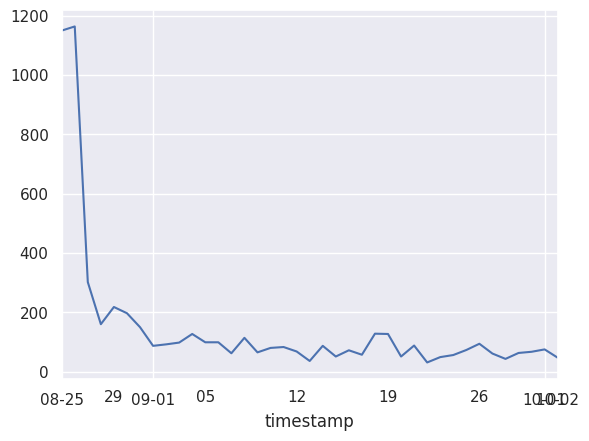

In [4]:
from matplotlib.dates import DateFormatter

ax = answers.set_index('timestamp').resample('D').size().plot.line()
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Quiz-level performance

In [5]:
def ci(ser):
    mu = ser.mean()
    sigma = ser.sem()
    return f'{mu:.02f} ± {2*sigma:.02f} (N = {len(ser)})'
answers.groupby(['quizName', 'version']).frac_correct.apply(ci)

quizName                                         version
ch01-01-installation                             0          0.75 ± 0.03 (N = 684)
ch01-02-hello-world                              0          0.90 ± 0.02 (N = 602)
ch01-03-hello-cargo                              0          0.90 ± 0.02 (N = 452)
ch03-01-variables-and-mutability-sec1-variables  1          0.93 ± 0.02 (N = 353)
ch03-01-variables-and-mutability-sec2-constants  0           0.77 ± 0.10 (N = 48)
                                                 1          0.67 ± 0.04 (N = 256)
ch03-01-variables-and-mutability-sec3-shadowing  0          0.59 ± 0.04 (N = 300)
ch03-02-data-types-sec1-scalar                   0          0.57 ± 0.04 (N = 245)
ch03-02-data-types-sec2-compound                 0          0.60 ± 0.05 (N = 217)
ch03-03-functions-sec1-parameters                0          0.76 ± 0.04 (N = 175)
ch03-03-functions-sec2-expressions               0          0.84 ± 0.04 (N = 174)
ch03-05-control-flow-sec1-if             

In [6]:
answers.groupby('quizName').frac_correct.describe()[['count', 'mean', '50%']].sort_values('quizName')

,count,mean,50%
quizName,,,
ch01-01-installation,684.0,0.747076,1.000000
ch01-02-hello-world,602.0,0.901993,1.000000
ch01-03-hello-cargo,452.0,0.899336,1.000000
ch03-01-variables-and-mutability-sec1-variables,353.0,0.928234,1.000000
ch03-01-variables-and-mutability-sec2-constants,304.0,0.689145,0.750000
ch03-01-variables-and-mutability-sec3-shadowing,300.0,0.588333,0.500000
ch03-02-data-types-sec1-scalar,245.0,0.571429,0.666667
ch03-02-data-types-sec2-compound,217.0,0.603687,0.500000
ch03-03-functions-sec1-parameters,175.0,0.760000,1.000000


In [7]:
import subprocess as sp

TAGS = ['ownership-incompleteness', 'borrow-promotion']

commit_tags = {
    tag: utils.date_for_commit(sp.check_output(f'git rev-list -n 1 {tag}', shell=True).decode('utf-8').strip())
    for tag in TAGS
}

In [8]:
interventions = [
    (('ch04-01-ownership-sec1-move', 3), ('ch04-01-ownership-sec3-functions', 2), 'ownership-incompleteness'),
    (('ch04-02-references-sec2-mut', 0), ('ch04-02-references-sec2-mut', 0), 'borrow-promotion')
]

for (before, after, tag) in interventions:
    def f(q, prior):
        df = answers_flat
        (quiz, question) = q
        df = df[(df.quizName == quiz) & (df.question == question)]
        df = df[df.timestamp.dt.date < commit_tags[tag].date()] if prior else df[df.timestamp.dt.date >= commit_tags[tag].date()]
        low, upp = proportion_confint(df.correct.sum(), len(df))
        print(f'prior={prior}, N={len(df)}, {df.correct.mean()}, correct=[{low:.02}-{upp:.02}]')
        
    print(tag)
    f(before, True)
    f(after, False)


ownership-incompleteness
prior=True, N=89, 0.1797752808988764, correct=[0.1-0.26]
prior=False, N=48, 0.5416666666666666, correct=[0.4-0.68]
borrow-promotion
prior=True, N=62, 0.3870967741935484, correct=[0.27-0.51]
prior=False, N=46, 0.391304347826087, correct=[0.25-0.53]


In [9]:
answers_flat[(answers_flat.quizName == 'ch04-01-ownership-sec3-functions') & (answers_flat.question == 2)].sort_values('timestamp')

,sessionId,quizName,quizHash,commitHash,timestamp,attempt,version,frac_correct,answer,correct,question
2427,3bb96cd5-7926-473b-ba53-58826f668c11,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,df5c9626c92a916d4e4583afb3400f89ab89fb34,2022-09-07 11:08:01.744,0.0,1,0.666667,"{'doesCompile': False, 'lineNumber': 3}",False,2
5217,75bdc489-fb9b-4716-b6b0-a437f9338c24,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-08 06:46:15.187,0.0,1,0.666667,"{'doesCompile': False, 'lineNumber': 6}",False,2
10476,dcfac6ec-4583-4008-b753-b9e4be8f03c0,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-08 22:03:51.054,0.0,1,1.000000,"{'doesCompile': False, 'lineNumber': 8}",True,2
6208,85688bd5-dd48-4060-b00a-f9af41afd6d0,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-08 22:56:12.960,0.0,1,0.666667,"{'doesCompile': False, 'lineNumber': 2}",False,2
7743,a1fc0485-733e-4663-8640-bb2cc1349d16,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-09 04:48:48.324,0.0,1,1.000000,"{'doesCompile': False, 'lineNumber': 8}",True,2
4103,60fead7a-b366-4f59-b9cd-d011f06cc9de,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-09 11:15:30.705,0.0,1,0.666667,"{'doesCompile': False, 'lineNumber': 8}",True,2
3057,4ad32f81-dc22-442c-8539-dd45ceed7e79,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-09 17:46:40.363,0.0,1,0.333333,"{'doesCompile': True, 'stdout': 'hello'}",False,2
10906,e81e2796-47ee-4da4-a5ad-e790e0a35e0a,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-09 20:10:33.872,0.0,1,1.000000,"{'doesCompile': False, 'lineNumber': 8}",True,2
6530,8c3d6689-6048-45d3-b413-fef5e2ae768f,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-10 10:52:07.470,0.0,1,1.000000,"{'doesCompile': False, 'lineNumber': 8}",True,2
4526,68d83de9-385d-4e31-a723-c7816335f899,ch04-01-ownership-sec3-functions,0b805d9aadba201bc93601142ac92876,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-10 12:25:39.835,0.0,1,0.666667,"{'doesCompile': True, 'stdout': 'hello'}",False,2


In [10]:
answers_flat[(answers_flat.quizName == 'ch04-02-references-sec2-mut') & (answers_flat.question == 0)].sort_values('timestamp')

,sessionId,quizName,quizHash,commitHash,timestamp,attempt,version,frac_correct,answer,correct,question
6598,8c53c44b-d2ea-4de5-8730-2424f65ebedc,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,42bcd85d8fa4cef57ef39a5478d23d587fc68f98,2022-08-25 17:22:25.444,0.0,0,0.0,"{'doesCompile': True, 'stdout': '2'}",False,0
7299,974b6a48-d3cc-44b2-bea8-fb3b4f189225,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,42bcd85d8fa4cef57ef39a5478d23d587fc68f98,2022-08-25 17:42:27.271,0.0,0,0.0,"{'doesCompile': True, 'stdout': '2'}",False,0
3670,593d256f-2549-494e-87c3-9c1a8049a9b9,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,42bcd85d8fa4cef57ef39a5478d23d587fc68f98,2022-08-25 17:45:52.415,0.0,0,0.0,"{'doesCompile': True, 'stdout': '2'}",False,0
3995,609cb914-a268-46bb-94c3-f7f18a36f160,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,42bcd85d8fa4cef57ef39a5478d23d587fc68f98,2022-08-25 18:02:25.649,0.0,0,1.0,"{'doesCompile': False, 'lineNumber': 7}",True,0
1800,2c8603d0-a6ce-4431-9d1e-13c3573c63da,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,42bcd85d8fa4cef57ef39a5478d23d587fc68f98,2022-08-25 18:09:33.040,0.0,0,0.5,"{'doesCompile': False, 'lineNumber': 7}",True,0
...,...,...,...,...,...,...,...,...,...,...,...
7422,998362e8-c236-472c-b81e-ac156ddbe76b,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-29 22:23:59.774,0.0,0,0.0,"{'doesCompile': True, 'stdout': '1'}",False,0
6964,918b09c7-3652-48a3-9dcc-38abe0c97d80,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-30 03:35:00.230,0.0,0,0.5,"{'doesCompile': False, 'lineNumber': 7}",True,0
10734,e4994d67-9c57-4ce6-9694-613733600ff2,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-09-30 20:11:47.337,0.0,0,0.5,"{'doesCompile': False, 'lineNumber': 7}",True,0
3496,53b7c7a3-e217-4385-8c42-3d76816174db,ch04-02-references-sec2-mut,a9f8c3f7377dc38a42d84cee2706ec68,e693ecc75f56cc7b327a142b5db20593425c22a9,2022-10-01 15:22:50.477,0.0,0,0.0,"{'doesCompile': True, 'stdout': '2'}",False,0


# Question-level performance

In [11]:

for quiz_name, versions in sorted(quizzes.quizzes.items(), key=lambda t: t[0]):
    schema = max(versions['schemas'].values(), key=lambda d: d['version'])['schema']
    quiz_answers = answers[answers.quizName == quiz_name]
    N = len(quiz_answers)
    if N < 2: continue
    
    meta = [
        {
            'n': 0,
            'bad_answers': []
        } 
        for _ in range(len(schema['questions']))
    ]
    for user_answers in quiz_answers.answers:
        for i, answer in enumerate(user_answers):
            m = meta[i]
            if answer['correct']:
                m['n'] += 1
            else:
                m['bad_answers'].append(answer['answer'])
    
    
    print(f'{"="*10} QUIZ: {quiz_name} {"="*10}')
    for i, q in enumerate(schema['questions']):
        m = meta[i]
        lower, upper = proportion_confint(m['n'], N)
        print(f"QUESTION {i+1}")
        print(f'%correct: {m["n"]/N:.02f} ([{lower:.02f} - {upper:.02f}], N = {N})')
        pprint(q['prompt'])
        print(m['bad_answers'])
        print()
    
    print('\n\n')

========== QUIZ: ch01-01-installation ==========
QUESTION 1
%correct: 0.75 ([0.71 - 0.78], N = 684)
{'prompt': 'What is the name of the command-line tool for managing the version '
           'of Rust on your machine?'}
[{'answer': '1.0'}, {'answer': 'cargo'}, {'answer': 'cargo'}, {'answer': 'cargo'}, {'answer': 'cargo'}, {'answer': 'cargo'}, {'answer': 'cargo'}, {'answer': 'rustc'}, {'answer': 'rustc'}, {'answer': 'rustc'}, {'answer': 'rustc'}, {'answer': 'rust up'}, {'answer': 'Cli'}, {'answer': '1.63'}, {'answer': 'rustc'}, {'answer': 'Cargo'}, {'answer': 'rutsup'}, {'answer': 'rustc'}, {'answer': 'rustc --version'}, {'answer': 'rustc'}, {'answer': 'cargo'}, {'answer': 'rustc'}, {'answer': 'rustc'}, {'answer': 'cargo'}, {'answer': 'cargo'}, {'answer': 'rustc'}, {'answer': 'rust-up'}, {'answer': 'Cargo'}, {'answer': 'cargo'}, {'answer': 'nix'}, {'answer': 'cargo'}, {'answer': 'crab'}, {'answer': 'cargo'}, {'answer': 'cargo --version'}, {'answer': 'cargo'}, {'answer': 'cargo'}, {'answ

IndexError: list index out of range

# User-level performance

In [ ]:
answers.groupby('sessionId').frac_correct.describe()[['count', 'mean', '50%']].sort_values('count')